In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import statistics
from numpy.lib.stride_tricks import as_strided
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [59]:
# import updated data
data = pd.read_csv("./updated_data.csv")#, header=None, names=["timestamp","chan0_raw","chan1_raw","chan0_hp","chan1_hp","quat_x","quat_y","quat_z","quat_w","gyro_x","gyro_y","gyro_z","acc_x","acc_y","acc_z","label","rep","trial"])


In [60]:
data

,timestamp,chan0_raw,chan1_raw,chan0_hp,chan1_hp,quat_x,quat_y,quat_z,quat_w,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,label,rep,trial
0,1514824.503,12535249,12566283,-11889,17295,0.321960,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1,1
1,1514827.496,12536264,12559246,-2063,13384,0.321960,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1,1
2,1514830.493,12538584,12565279,2757,16008,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1,1
3,1514833.500,12546745,12567024,7504,5644,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1,1
4,1514836.498,12537375,12545467,-3855,-15893,0.321960,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14976,1618167.393,11942866,12916517,-32480,-78200,-0.312927,-0.112427,-0.932861,0.138855,-114.255844,-1219.997200,82.026960,0.363281,-1.464844,-9.00000,4,3,15
14977,1618170.388,11881160,12934589,-43544,-69885,-0.312927,-0.112427,-0.932861,0.138855,-114.255844,-1219.997200,82.026960,0.363281,-1.464844,-9.00000,4,3,15
14978,1618173.377,11869705,12927326,-25592,-73242,-0.264465,-0.108093,-0.946472,0.150146,-104.464080,-1181.054100,103.904560,0.363281,-1.464844,-9.00000,4,3,15
14979,1618176.442,11898127,12957446,40027,-17502,-0.218140,-0.103271,-0.956909,0.161560,-94.336610,-1117.715300,125.782140,0.363281,-1.464844,-9.00000,4,3,15


In [61]:
data = data[["timestamp","chan0_hp","chan1_hp","gyro_x","gyro_y","gyro_z","acc_x","acc_y","acc_z","label","rep","trial"]]


In [62]:
# function to segment data into overlapping windows
def windowed_view(arr, window, overlap):
    arr = np.asarray(arr)
    window_step = window - overlap
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap) // window_step,
                                  window)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) +
                   arr.strides[-1:])
    return as_strided(arr, shape=new_shape, strides=new_strides)

In [63]:
# create overlapping segments for each feature
acc_x_all_windows = []
acc_y_all_windows = []
acc_z_all_windows = []
gyro_x_all_windows = []
gyro_y_all_windows = []
gyro_z_all_windows = []
chan0_hp_all_windows = []
chan1_hp_all_windows = []

for trial_num in sorted(data["trial"].unique()):
    mask = (data["trial"] == trial_num)
    acc_x_windows = windowed_view(data[mask].acc_x,500,250)
    acc_y_windows = windowed_view(data[mask].acc_y,500,250)
    acc_z_windows = windowed_view(data[mask].acc_z,500,250)
    gyro_x_windows = windowed_view(data[mask].gyro_x,500,250)
    gyro_y_windows = windowed_view(data[mask].gyro_y,500,250)
    gyro_z_windows = windowed_view(data[mask].gyro_z,500,250)
    chan0_hp_windows = windowed_view(data[mask].chan0_hp,500,250)
    chan1_hp_windows = windowed_view(data[mask].chan1_hp,500,250)
    
    acc_x_all_windows.append(acc_x_windows.tolist())
    acc_y_all_windows.append(acc_y_windows.tolist())
    acc_z_all_windows.append(acc_z_windows.tolist())
    gyro_x_all_windows.append(gyro_x_windows.tolist())
    gyro_y_all_windows.append(gyro_y_windows.tolist())
    gyro_z_all_windows.append(gyro_z_windows.tolist())
    chan0_hp_all_windows.append(chan0_hp_windows.tolist())
    chan1_hp_all_windows.append(chan1_hp_windows.tolist())
    

In [64]:
# flatten nested lists
acc_x_all_windows = [item for sublist in acc_x_all_windows for item in sublist]
acc_y_all_windows = [item for sublist in acc_y_all_windows for item in sublist]
acc_z_all_windows = [item for sublist in acc_z_all_windows for item in sublist]
gyro_x_all_windows = [item for sublist in gyro_x_all_windows for item in sublist]
gyro_y_all_windows = [item for sublist in gyro_y_all_windows for item in sublist]
gyro_z_all_windows = [item for sublist in gyro_z_all_windows for item in sublist]
chan0_hp_all_windows = [item for sublist in chan0_hp_all_windows for item in sublist]
chan1_hp_all_windows = [item for sublist in chan1_hp_all_windows for item in sublist]

In [65]:
# zero_crossings function
def zero_crossings(x):
    ZC=0;
    for pos in range(len(x)-1):
        if ((x[pos] > 0 and x[pos+1] < 0) or (x[pos] < 0 and x[pos+1] > 0)) and (np.abs(x[pos]-x[pos+1]) >= 0):
            ZC=ZC+1;
    return ZC

In [66]:
# create engineered features for each window
acc_x_integrals = scipy.integrate.simps(acc_x_all_windows)
acc_y_integrals = scipy.integrate.simps(acc_y_all_windows)
acc_z_integrals = scipy.integrate.simps(acc_z_all_windows)
gyro_x_integrals = scipy.integrate.simps(gyro_x_all_windows)
gyro_y_integrals = scipy.integrate.simps(gyro_y_all_windows)
gyro_z_integrals = scipy.integrate.simps(gyro_z_all_windows)

acc_x_variance = [statistics.variance(x) for x in acc_x_all_windows]
acc_y_variance = [statistics.variance(x) for x in acc_y_all_windows]
acc_z_variance = [statistics.variance(x) for x in acc_z_all_windows]
gyro_x_variance = [statistics.variance(x) for x in gyro_x_all_windows]
gyro_y_variance = [statistics.variance(x) for x in gyro_y_all_windows]
gyro_z_variance = [statistics.variance(x) for x in gyro_z_all_windows]

acc_x_mean = [np.abs(np.mean(x)) for x in acc_x_all_windows]
acc_y_mean = [np.abs(np.mean(x)) for x in acc_y_all_windows]
acc_z_mean = [np.abs(np.mean(x)) for x in acc_z_all_windows]
gyro_x_mean = [np.abs(np.mean(x)) for x in gyro_x_all_windows]
gyro_y_mean = [np.abs(np.mean(x)) for x in gyro_y_all_windows]
gyro_z_mean = [np.abs(np.mean(x)) for x in gyro_z_all_windows]

acc_x_zc = [zero_crossings(x) for x in acc_x_all_windows]
acc_y_zc = [zero_crossings(x) for x in acc_y_all_windows]
acc_z_zc = [zero_crossings(x) for x in acc_z_all_windows]
gyro_x_zc = [zero_crossings(x) for x in gyro_x_all_windows]
gyro_y_zc = [zero_crossings(x) for x in gyro_y_all_windows]
gyro_z_zc = [zero_crossings(x) for x in gyro_z_all_windows]

chan0_integrals = scipy.integrate.simps(chan0_hp_all_windows)
chan1_integrals = scipy.integrate.simps(chan0_hp_all_windows)

chan0_ln_variance = [statistics.variance(x) for x in chan0_hp_all_windows]
chan1_ln_variance = [statistics.variance(x) for x in chan1_hp_all_windows]

chan0_mean = [np.abs(np.mean(x)) for x in chan0_hp_all_windows]
chan1_mean = [np.abs(np.mean(x)) for x in chan1_hp_all_windows]


In [68]:
# create dataframe of all window features
data_features = pd.DataFrame({"acc_x_integrals": acc_x_integrals,
                             "acc_x_integrals": acc_y_integrals,
                             "acc_x_integrals": acc_z_integrals,
                             "gyro_x_integrals": gyro_x_integrals,
                             "gyro_y_integrals": gyro_y_integrals,
                             "gyro_z_integrals": gyro_z_integrals,
                             "acc_x_variance": acc_x_variance,
                             "acc_y_variance": acc_y_variance,
                             "acc_z_variance": acc_z_variance,
                             "gyro_x_variance": gyro_x_variance,
                             "gyro_y_variance": gyro_y_variance,
                             "gyro_z_variance": gyro_z_variance,
                             "acc_x_mean": acc_x_mean,
                             "acc_y_mean": acc_y_mean,
                             "acc_z_mean": acc_z_mean,
                             "gyro_x_mean": gyro_x_mean,
                             "gyro_y_mean": gyro_y_mean,
                             "gyro_z_mean": gyro_z_mean,
                             "acc_x_zc": acc_x_zc,
                             "acc_y_zc": acc_y_zc,
                             "acc_z_zc": acc_z_zc,
                             "gyro_x_zc": gyro_x_zc,
                             "gyro_y_zc": gyro_y_zc,
                             "gyro_z_zc": gyro_z_zc,
                             "chan0_integrals": chan0_integrals,
                             "chan1_integrals": chan1_integrals,
                             "chan0_ln_variance": chan0_ln_variance,
                             "chan1_ln_variance": chan1_ln_variance,
                             "chan0_mean": chan0_mean,
                             "chan1_mean": chan1_mean}
                             )


In [69]:
features = ["acc_x_integrals","acc_x_integrals","acc_x_integrals","gyro_x_integrals","gyro_y_integrals","gyro_z_integrals",
            "acc_x_variance","acc_y_variance","acc_z_variance","gyro_x_variance","gyro_y_variance","gyro_z_variance",
            "acc_x_mean","acc_y_mean","acc_z_mean","gyro_x_mean","gyro_y_mean","gyro_z_mean","acc_x_zc","acc_y_zc",
            "acc_z_zc","gyro_x_zc","gyro_y_zc","gyro_z_zc","chan0_integrals","chan1_integrals", "chan0_ln_variance",
            "chan1_ln_variance", "chan0_mean", "chan1_mean"]
            

In [71]:
#poly = PolynomialFeatures(include_bias=False)

#X_poly = poly.fit_transform(IMU_features)

#IMU_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

In [72]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
data_scaled = ss.fit_transform(data_features)

In [73]:
# Instantiate PCA.
pca = PCA(random_state = 42)

# Fit PCA on the training data.
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

# Transform PCA on the training data.
data_pca = pca.transform(data_scaled)

In [74]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance: {np.round(var_exp,3)}')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {np.round(cum_var_exp,3)}')

Explained variance: [0.258 0.177 0.121 0.073 0.065 0.055 0.045 0.042 0.033 0.029 0.023 0.017
 0.015 0.01  0.009 0.008 0.006 0.004 0.003 0.002 0.002 0.001 0.001 0.001
 0.    0.    0.    0.   ]
Cumulative explained variance: [0.258 0.435 0.556 0.629 0.694 0.748 0.793 0.835 0.869 0.897 0.92  0.937
 0.952 0.962 0.971 0.98  0.986 0.99  0.993 0.995 0.997 0.998 0.998 0.999
 1.    1.    1.    1.   ]


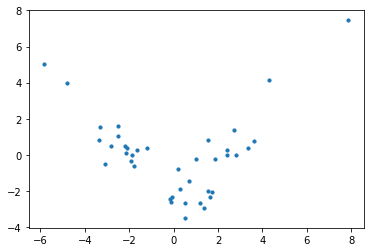

In [79]:
plt.scatter(data_pca[:,0],data_pca[:,1], s=10);

In [81]:
pd.DataFrame(data_pca).to_csv(f'./outputs/data_pca_01.csv', index=False)